In [2]:
import xarray as xr
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import HourLocator
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap,Normalize
import cmocean

In [4]:
root = "ipfs://QmfAzqPtR99owGURk27JV4Vgwun1CxRpKjomtkBxYufv5b"
dset_meteo = xr.open_dataset(f"{root}/DShip.zarr",engine="zarr")
dset_disdro = xr.open_dataset(
    f"{root}/disdrometer/DSD_METEOR_merged.zarr",engine="zarr")
dset_sea_snake = xr.open_dataset(f"{root}/SeaSnake/met_203_1_SeaSnake.zarr",engine="zarr")
dset_termo = xr.open_dataset(f"{root}/thermosalinograph/met_203_1_tsal.zarr",engine="zarr")
dset_lidart = xr.open_dataset(f"{root}/LICHT-LIDAR_t.zarr",engine="zarr")
dset_lidart_sel = dset_lidart.sel(time= slice('2024-09-08 06 ','2024-09-08 17:00:00'),alt=slice(0,600))
dset_raingauge = xr.open_dataset("ipfs://bafybeigxrptjacw3gwyowbw4d5n3aixp52qlgfhlj2cxdnhofcoxmkgmdi", engine="zarr")

In [5]:
#cloudnet
cloudnet = xr.open_dataset("ipns://latest.orcestra-campaign.org/products/METEOR/cloudnet.zarr", engine="zarr")
cloudnet

<xarray.Dataset> Size: 7GB
Dimensions:                 (time: 106200, height: 393)
Coordinates:
  * height                  (height) float32 2kB 120.3 135.3 ... 1.198e+04
  * time                    (time) datetime64[ns] 850kB 2024-08-17T00:00:15 ....
Data variables: (12/55)
    N_scaled                (time, height) float32 167MB ...
    Tw                      (time, height) float32 167MB ...
    Z                       (time, height) float32 167MB ...
    Z_bias                  (time) float32 425kB ...
    Z_error                 (time, height) float32 167MB ...
    Z_sensitivity           (time, height) float32 167MB ...
    ...                      ...
    rain_detected           (time) float64 850kB ...
    rainfall_rate           (time) float32 425kB ...
    target_classification   (time, height) float64 334MB ...
    v                       (time, height) float32 167MB ...
    v_sigma                 (time, height) float32 167MB ...
    width                   (time, height) float32 167MB ...
Attributes: (12/18)
    Conventions:         CF-1.8
    cloudnet_file_type:  der
    title:               Cloudnet droplet effective radius on RV Meteor durin...
    location:            RV Meteor
    year:                2024
    source:              RPG-Radiometer Physics RPG-FMCW-94\nLufft CHM15k\nEC...
    ...                  ...
    platform:            RV METEOR
    institution:         Leipzig Institute for Meteorology, Leipzig University
    instrument:          Cloudnet product based on cloud radar, ceilometer, m...
    creator_id:          ORCiD: 0000-0002-1164-3576
    keywords:            Cloudnet, effective radius, droplet
    featureType:         trajectoryProfile

In [6]:
#sea_pool_file = '/Users/hans/Documents/bow_tie/SEA-POOL/SEA-POL_gridded_rainrate_spatial_means_masked.nc'
sea_pool_file = '../processed_data/SEA-POL_4b_rainrate_2D_spatial_means_masked_reg10.nc'
dset_pool = xr.open_dataset(sea_pool_file,chunks='auto' )

In [7]:
#sea_pool_qv_file = '/Users/hans/Documents/bow_tie/SEA-POOL/qvp_1D.nc'
sea_pool_qv_file = '/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4b/PICCOLO_level4b_qvp_1D.nc'
dset_pool_qv = xr.open_dataset(sea_pool_qv_file,chunks='auto' )

In [8]:
lwc = cloudnet.lwc.sel(time=slice('2024-09-08 06:00', '2024-09-08 17:00'),height=slice(0,6000))

#interpolate over regular missing data (3 time steps of NaN in a row)

def interpolate_short_nan_runs(arr, max_nan_run=3):
    arr = arr.copy()
    isnan = np.isnan(arr)
    # Find runs of NaNs
    idx = np.arange(arr.size)
    nan_runs = []
    run_start = None
    for i, val in enumerate(isnan):
        if val and run_start is None:
            run_start = i
        elif not val and run_start is not None:
            if i - run_start <= max_nan_run:
                nan_runs.append((run_start, i))
            run_start = None
    if run_start is not None and arr.size - run_start <= max_nan_run:
        nan_runs.append((run_start, arr.size))
    # Interpolate over short runs
    for start, end in nan_runs:
        arr[start:end] = np.interp(idx[start:end], idx[~isnan], arr[~isnan])
    return arr

# Apply to each height level (axis=0)
lwc_interp = np.apply_along_axis(interpolate_short_nan_runs, 0, lwc.values, max_nan_run=3)
lwc = xr.DataArray(lwc_interp, coords=lwc.coords, dims=lwc.dims)

In [9]:
lwc

<xarray.DataArray (time: 1322, height: 242)> Size: 1MB
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0937025e-04,
        1.3671265e-04, 1.6405505e-04],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0046838e-04,
        1.2558531e-04, 1.5070225e-04],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.9734867e-05,
        5.2979769e-05, 6.6224675e-05],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], shape=(1322, 242), dtype=float32)
Coordinates:
  * height   (height) float32 968B 120.3 135.3 150.2 ... 5.939e+03 5.978e+03
  * time     (time) datetime64[ns] 11kB 2024-09-08T06:00:15 ... 2024-09-08T17...

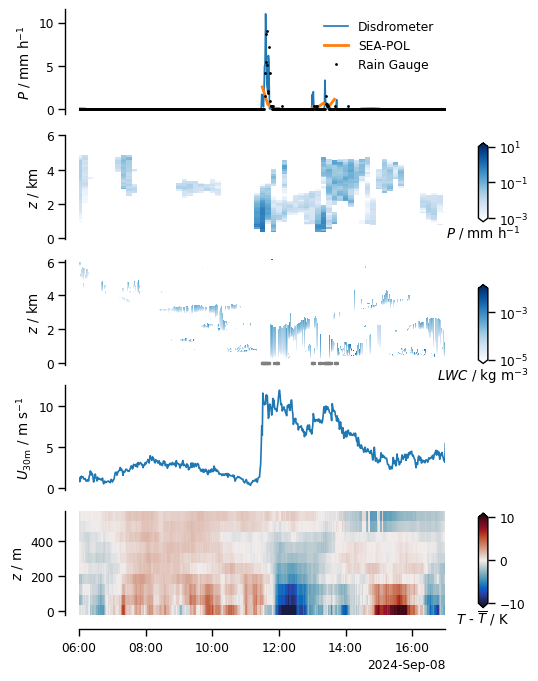

In [19]:
sns.set_context("paper")
fig = plt.figure(figsize=(12/2.54,20/2.54),facecolor='white')
ax1=fig.add_axes([0.97,0.61,0.02,0.10])
ax1a=fig.add_axes([0.97,0.43,0.02,0.10])
ax2=fig.add_axes([0.97,0.12,0.02,0.12])

ax= fig.add_subplot(511)
dset_disdro.rain_rate_qc.sel(
    time=slice('2024-09-08 06:00','2024-09-08 17:00')).plot(label='Disdrometer')
dset_pool.rain1_int.sel(
    time=slice('2024-09-08 06:00','2024-09-08 17:00')).plot(linewidth='2',label='SEA-POL')
dset_raingauge.RR_SRM.sel(
    time=slice('2024-09-08 06:00','2024-09-08 17:00')).plot(
    marker='o',linestyle='',markersize=1,color='black',label='Rain Gauge')
ax.set_title(None)
ax.set_xlabel(None)
ax.set_xlim([dset_lidart_sel.time[0],dset_lidart_sel.time[-1]])
ax.set_xticks([])
ax.set_xticklabels({})
ax.set_ylabel(r'$P$ / mm h$^{-1}$')
sns.despine(offset=10,ax=ax)
ax.spines['bottom'].set_visible(False)
plt.legend(frameon=False)

ax= fig.add_subplot(512)
rain_cmap=plt.get_cmap('Blues').copy()
rain_cmap.set_under(color='white') #set values below vmin to white
plot_seapool = dset_pool_qv.assign_coords({'Z':dset_pool_qv.Z.values/1000}).RAINRATE.sel(
    time=slice('2024-09-08 06:00','2024-09-08 17:00'),Z=slice(0,6)).plot(
    x='time',cmap=rain_cmap, norm=colors.LogNorm(vmin=0.001,vmax=10),shading='auto',add_colorbar=False)
ax.set_xlim([dset_lidart_sel.time[0],dset_lidart_sel.time[-1]])
sns.despine(offset=10,ax=ax)
ax.set_xticks([])
ax.set_xticklabels({})
ax.spines['bottom'].set_visible(False)
ax.set_ylabel(r'$z$ / km')

## Cloud net liquid water content
#ax= fig.add_subplot(513)
#rain_cmap=plt.get_cmap('Blues').copy()
#rain_cmap.set_under(color='white') #set values below vmin to white
#plot_cloudnet = cloudnet.assign_coords({'height':cloudnet.height.values/1000}).lwc.sel(
#    time=slice('2024-09-08 06:00','2024-09-08 17:00'),height=slice(0,6)).plot(
#    x='time',cmap=rain_cmap, norm=colors.LogNorm(vmin=0.00001,vmax=0.01),shading='auto',add_colorbar=False)
#ax.set_xlim([dset_lidart_sel.time[0],dset_lidart_sel.time[-1]])
#ax.set_ylim([-0.1,6.1])
#sns.despine(offset=10,ax=ax)
#ax.set_xticks([])
#ax.set_xticklabels({})
#ax.spines['bottom'].set_visible(False)
#ax.set_ylabel(r'$z$ / km')

ax= fig.add_subplot(513)
rain_cmap=plt.get_cmap('Blues').copy()
rain_cmap.set_under(color='white') #set values below vmin to white
plot_cloudnet = lwc.assign_coords({'height':lwc.height.values/1000}).plot(
    x='time',cmap=rain_cmap, norm=colors.LogNorm(vmin=0.00001,vmax=0.01),shading='auto',add_colorbar=False)
ax.set_xlim([dset_lidart_sel.time[0],dset_lidart_sel.time[-1]])
ax.set_ylim([-0.1,6.1])
sns.despine(offset=10,ax=ax)
ax.set_xticks([])
ax.set_xticklabels({})
ax.spines['bottom'].set_visible(False)
ax.set_ylabel(r'$z$ / km')

# Add black dots for rain attenuation flag == 1
rain_flag = cloudnet.rain_detected.sel(time=slice('2024-09-08 06:00', '2024-09-08 17:00'))
rain_flag_mask = (rain_flag.transpose() == 1)
#make array of zeros length of rain_flag_mask
zeros_array = np.zeros(rain_flag_mask.shape)
ax.scatter(lwc.time.values[rain_flag_mask],zeros_array[rain_flag_mask],color='gray', s=1, marker='s',label='Rain Detected')

ax= fig.add_subplot(514)
dset_meteo.wspd.sel(time=slice('2024-09-08 06','2024-09-08 17:00')).plot()
ax.set_xlabel(None)
ax.set_xlim([dset_lidart_sel.time[0],dset_lidart_sel.time[-1]])
ax.set_xticks([])
ax.set_xticklabels({})
ax.set_ylabel(r'$U_\mathrm{30m}$ / m s$^{-1}$')
sns.despine(offset=10,ax=ax)
ax.spines['bottom'].set_visible(False)

ax= fig.add_subplot(515)
plot_cb = (dset_lidart_sel.ta -dset_lidart_sel.ta.mean('time')).plot(
    y='alt',
    cmap=cmocean.cm.balance,
    vmin=-10,vmax=10,
    add_colorbar=False)
ax.set_xlim([dset_lidart_sel.time[0],dset_lidart_sel.time[-1]])
sns.despine(offset=10,ax=ax)
plt.subplots_adjust(hspace=0.2)
ax.xaxis.set_major_locator(HourLocator(byhour=range(0,24,2)))
ax.set_ylabel(r'$z$ / m')
ax.set_xlabel(None)

b1 = plt.colorbar(plot_seapool,
                  extend='both',
                  orientation='vertical',
                  cax=ax1,shrink=0.8,pad=0.09)
b1.ax.set_xlabel(r"$P$ / mm h$^{-1}$");

b1a = plt.colorbar(plot_cloudnet,
                  extend='both',
                  orientation='vertical',
                  cax=ax1a,shrink=0.8,pad=0.09)
b1a.ax.set_xlabel(r"$LWC$ / kg m$^{-3}$");

#b1a = plt.colorbar(plot_cloudnet,
#                  extend='both',
#                  orientation='vertical',
#                  cax=ax1a,shrink=0.8,pad=0.09)
#b1a.ax.set_xlabel(r"$Z$ / dBZ");
#b1a.ax.set_yticks([-40,-20,0,20])

b2 = plt.colorbar(plot_cb,
                  extend='both',
                  orientation='vertical',
                  cax=ax2,shrink=0.8,pad=0.09)
b2.ax.set_xlabel(r"$T$ - $\overline{T}$ / K");
b2.ax.set_yticks([-10,0,10])

plt.savefig('../figures/precip_wind_temp_wind_gust.pdf',
            format='pdf',bbox_inches='tight',orientation={'landscape'})